### Question 1

In [1]:
ricker_det <- function(n0, a, b, nyears){
  n <- numeric(nyears)                  #empty vector to fill in with n's
  n[1] <- n0                            #initial population size
  for(i in 2:nyears){                   #start at t=2
    n[i] <- a * n[i-1] * exp(-b*n[i-1]) #ricker equation above
  }
  return(n)  
}

In [2]:
nyears <- 40
ricker_alpha <- 1.5
ricker_beta <- 0.0003
equilibrium <- log(ricker_alpha)/ricker_beta 
n0 <- round(0.1 * equilibrium)  #make integer


rick_det_dynamics <- ricker_det(
    n0 = n0, 
    a = ricker_alpha,
    b = ricker_beta, 
    nyears = nyears
)

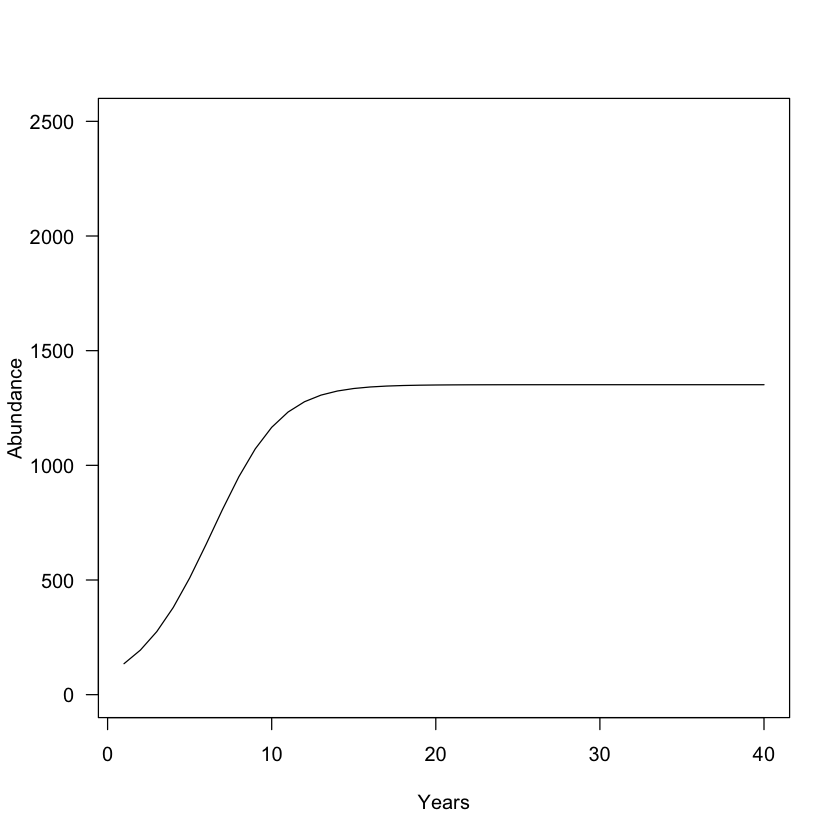

In [3]:
plot(1:40, rick_det_dynamics,ylab="Abundance",xlab="Years",
     las=1, type="l", pch=16, ylim=c(0,2500))

In [4]:
ricker_stoch <- function(n0, a, b, nyears){
  n <- numeric(nyears)                  
  n[1] <- n0                            
  for(i in 2:nyears){                   
    n[i] <- rpois(n=1, lambda = a*n[i-1]*exp(-b * n[i-1]))
  }
  return(n)  
}

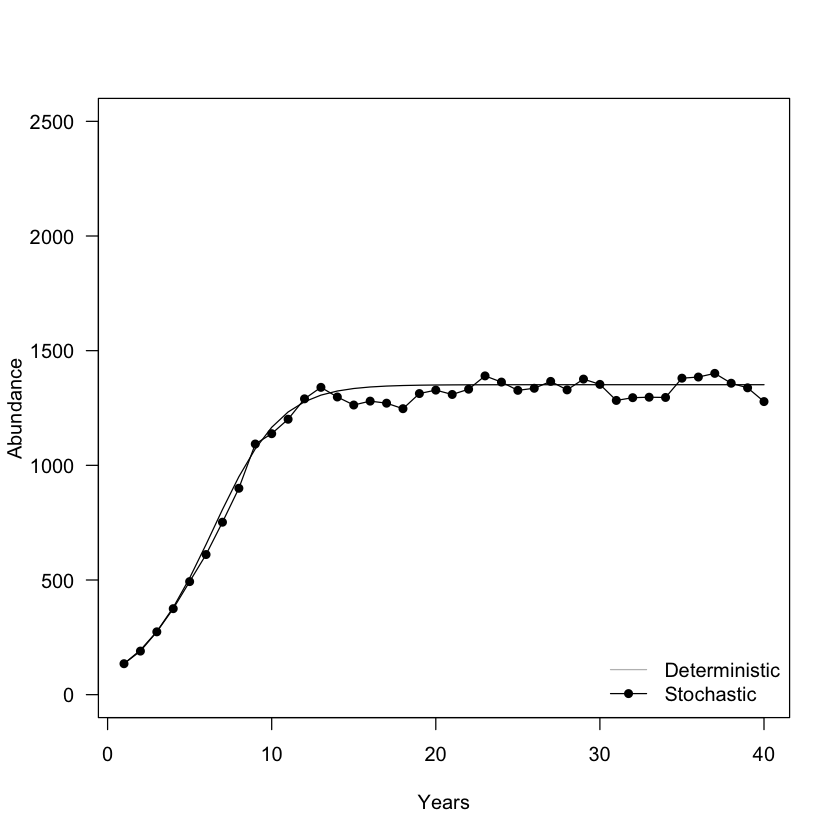

In [15]:
nyears <- 40
ricker_alpha <- 1.5
ricker_beta <- 0.0003
equilibrium <- log(ricker_alpha)/ricker_beta 
n0 <- round(0.1 * equilibrium)  #make integer


ricker_stoch_dynamics = ricker_stoch(
    n0 = n0, 
    a = ricker_alpha, 
    b = ricker_beta, 
    nyears = nyears
)

plot(1:40, rick_det_dynamics, ylab="Abundance",xlab="Years",
     las=1, type="l", pch=16, ylim=c(0,2500))
lines(1:40, ricker_stoch_dynamics,ylab="Abundance",xlab="Years",
     las=1, type="o", pch=16, ylim=c(0,2500))
legend("bottomright",legend=c("Deterministic","Stochastic"),bty="n",
       pch=c(NA,16),lty =1,col=c("grey","black"))


In [18]:
ricker_ssm <- function(n0, a, b, nyears, sig.y){
  n <- y <- numeric(nyears)    #empty na nd y vectors to fill
  n[1] <- n0                   #initial n
  y[1] <- rnorm(n=1, mean=n[1], sd = sig.y)
  for(i in 2:nyears){#start at t=2
    n[i] <- rpois(n=1, lambda=a * n[i - 1] * exp(-b * n[i - 1])) #stochastic state model here
    y[i] <- rnorm(n=1, mean=n[i], sd=sig.y) #stochastic observation model here
  }
  return(list(n=n,y=y))  
}

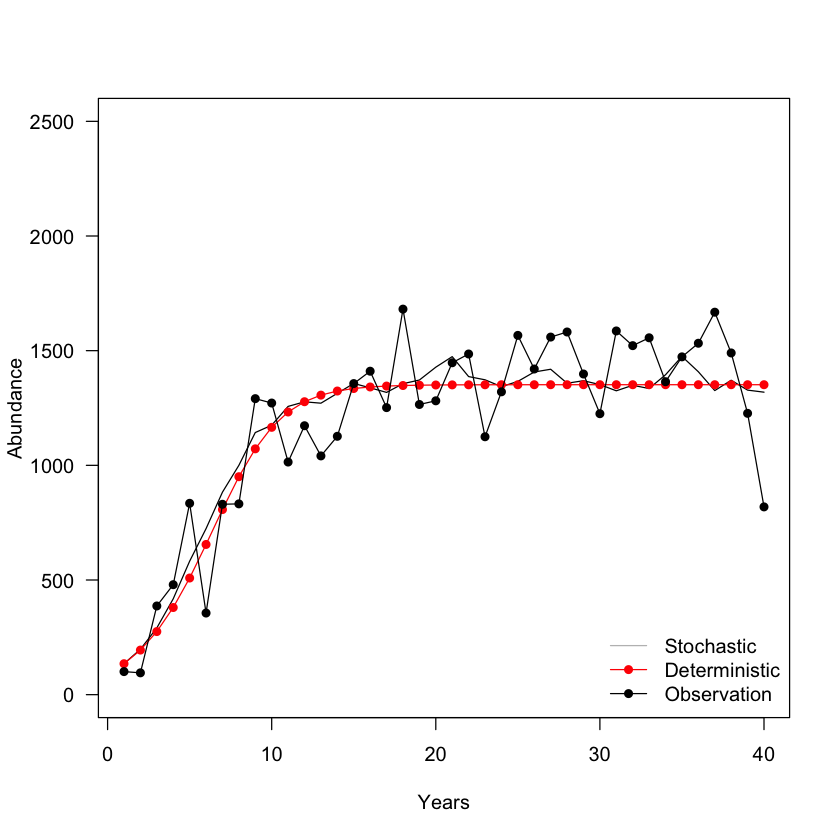

In [42]:
ricker_ssm_data = ricker_ssm(n0=n0, a=ricker_alpha, b=ricker_beta, nyears, 200)
plot(1:40, ricker_ssm_data$n, ylab="Abundance",xlab="Years",
     las=1, type="l", pch=16, ylim=c(0,2500))
lines(1:40, rick_det_dynamics,ylab="Abundance",xlab="Years",
     las=1, type="o", pch=16, ylim=c(0,2500), col="red")
lines(1:40, ricker_ssm_data$y,ylab="Abundance",xlab="Years",
     las=1, type="o", pch=16, ylim=c(0,2500))
legend("bottomright",legend=c("Stochastic", "Deterministic", "Observation"),bty="n",
       pch=c(NA,16,16),lty =1,col=c("grey", "red", "black"))

In [46]:
#a function to simulate deterministic dynamics
ricker_ssm_log <- function(n0, a, b, nyears, cv){
  n <- y <- numeric(nyears)    #empty na nd y vectors to fill
  sigma_sq = log(cv^2 + 1)
  sd = sqrt(sigma_sq)
  n[1] <- n0                   #initial n
  y[1] <- rlnorm(n=1, mean=log(n[1]) - sigma_sq/2, sd = sd)
  for(i in 2:nyears){#start at t=2
    n[i] <- rpois(n=1, lambda=a * n[i - 1] * exp(-b * n[i - 1])) #stochastic state model here
    y[i] <- rlnorm(n=1, mean=log(n[i]) - sigma_sq/2, sd=sd) #stochastic observation model here
  }
  return(list(n=n,y=y))  
}

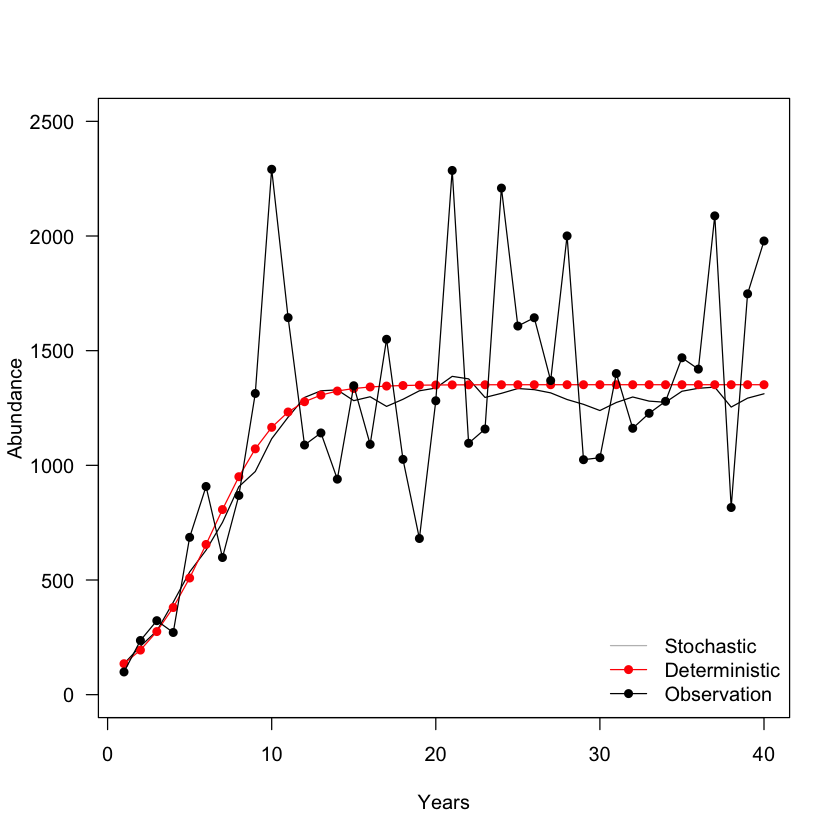

In [52]:
ricker_ssm_log_data = ricker_ssm_log(n0=n0, a=ricker_alpha, b=ricker_beta, nyears, 0.3)
plot(1:40, ricker_ssm_log_data$n, ylab="Abundance",xlab="Years",
     las=1, type="l", pch=16, ylim=c(0,2500))
lines(1:40, rick_det_dynamics,ylab="Abundance",xlab="Years",
     las=1, type="o", pch=16, ylim=c(0,2500), col="red")
lines(1:40, ricker_ssm_log_data$y,ylab="Abundance",xlab="Years",
     las=1, type="o", pch=16, ylim=c(0,2500))
legend("bottomright",legend=c("Stochastic", "Deterministic", "Observation"),bty="n",
       pch=c(NA,16,16),lty =1,col=c("grey", "red", "black"))

### Question 2

In [103]:
project_population = function(years, n0, phi, pi, rho, cv) {
    
    proj = matrix(NA, 2, years)
    proj[, 1] = n0
    y = matrix(NA, 2, years)
    sigma_sq = log(cv^2 + 1)
    # set initial observations, at the beginning of the period
    y[1, 1] = rlnorm(n=1, meanlog=log(proj[1, 1]) - sigma_sq/2, sd=sqrt(sigma_sq))
    y[2, 1] = rlnorm(n=1, meanlog=log(proj[2, 1]) - sigma_sq/2, sd=sqrt(sigma_sq))
    
    for (year in 2:years) {
        # survival
        proj[1, year] = rbinom(n=1, size=proj[1, year - 1], prob=phi[1])
        proj[2, year] = rbinom(n=1, size=proj[2, year - 1], prob=phi[2])
        
        #growth
        no_growth = rbinom(n=1, proj[1, year], 1 - pi)
        growth = proj[1, year] - no_growth
        proj[2, year] = proj[2, year] + growth
        proj[1, year] = no_growth
        
        #birth
        new_immature = rbinom(n=1, size=proj[2, year], prob=rho)
        proj[1, year] = proj[1, year] + new_immature
        
        y[1, year] = rlnorm(n=1, meanlog=log(proj[1, year]) - sigma_sq/2, sd=sqrt(sigma_sq))
        y[2, year] = rlnorm(n=1, meanlog=log(proj[2, year]) - sigma_sq/2, sd=sqrt(sigma_sq))
    }
    
    return (list(proj=proj, y=y))
}

In [104]:
n0 = c(50, 70)
phi = c(0.5, 0.71)
pi = 0.6
rho = 0.8
projected = project_population(40, n0=n0, phi=phi, pi=pi, rho=rho, cv = 0.3)

In [105]:
proj_df <- data.frame(Abundance = c(projected$proj[1, ],          # immature population
                                    projected$proj[2, ],          # mature population
                                    apply(projected$proj, 2, sum), # total population
                                    projected$y[1, ],             # immature observations
                                    projected$y[2, ],             # mature observations
                                    apply(projected$y, 2, sum)  # total lo phi scenario
                                    ),
                      Stage = rep(c("Immature", "Mature", "Total"),each=40, times =2),
                      State = rep(c("Population","Observed"),each=40*3),
                      Year = rep(1:40,6))
str(proj_df)

'data.frame':	240 obs. of  4 variables:
 $ Abundance: num  50 66 73 72 75 72 65 68 63 73 ...
 $ Stage    : chr  "Immature" "Immature" "Immature" "Immature" ...
 $ State    : chr  "Population" "Population" "Population" "Population" ...
 $ Year     : int  1 2 3 4 5 6 7 8 9 10 ...


In [98]:
options(warn=-1)
library(ggplot2)
library(ggthemes)

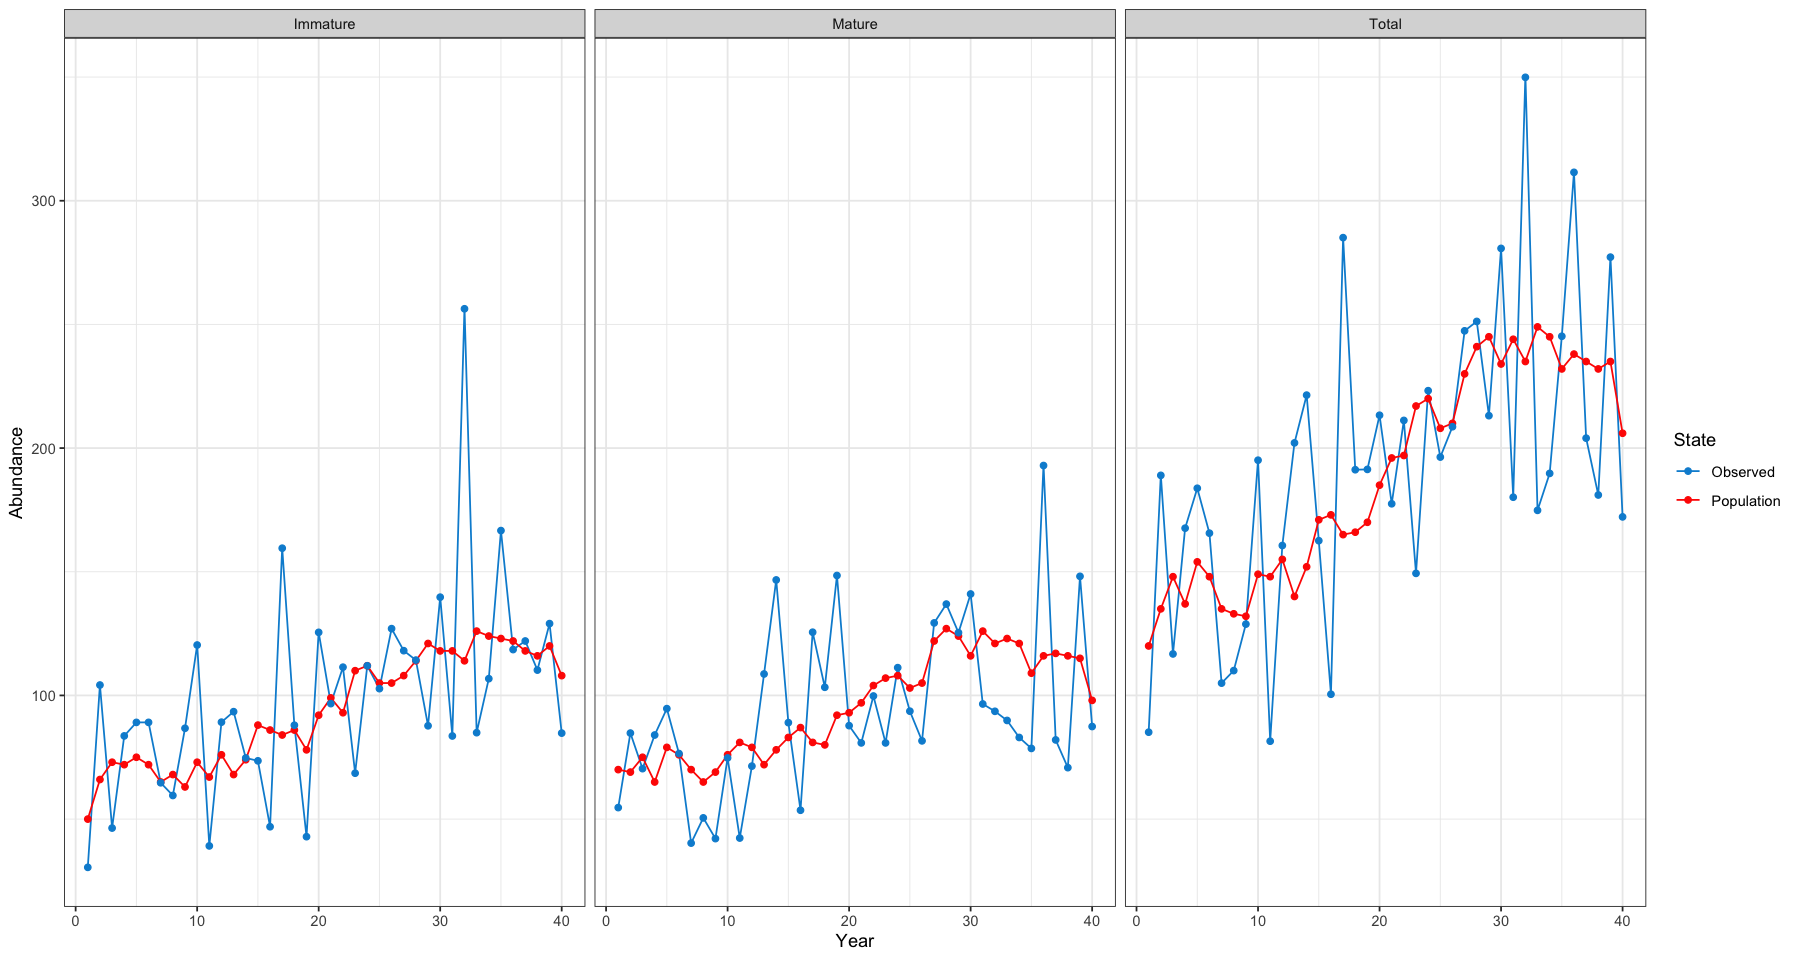

In [106]:
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data=proj_df, aes(x=Year, y=Abundance, group=State, color=State, fill=State)) + 
  geom_line() +
  geom_point() + 
  facet_wrap(.~Stage) + 
  theme_bw() + 
  scale_color_fivethirtyeight() +
  scale_fill_fivethirtyeight()